## Experiments

In [267]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [268]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [269]:
df = pd.read_csv("dataset/dataset.csv")

In [270]:
print ("No of rows & columns", df.shape)

No of rows & columns (965, 7)


In [271]:
## Columns
df.columns

Index(['Aggregation Type', 'Description', 'Dimensions', 'Metric',
       'Metric Display Name', 'Unit', 'resource'],
      dtype='object')

### Resources

In [272]:
print ("No of unique resources: %d" % (df.resource.value_counts().shape[0]))

No of unique resources: 59


In [273]:
def getResourceNamespace(resource):
    return resource.split('/')[0]

def getResourceName(resource):
    return "/".join(resource.split('/')[1:])

In [274]:
df['ResourceNamespace'] = df['resource'].apply(lambda x: getResourceNamespace(x))
df['ResourceName'] = df['resource'].apply(lambda x: getResourceName(x))

In [275]:
print ("No of resource namespaces: %d" % (df['ResourceNamespace'].value_counts().shape[0]))
print ("No of resource name: %d" % (df['ResourceName'].value_counts().shape[0]))

No of resource namespaces: 34
No of resource name: 50


### Aggreagation Type

col_0             count
Aggregation Type       
Average             309
Count                 5
Last                  6
Maximum             123
Total               522


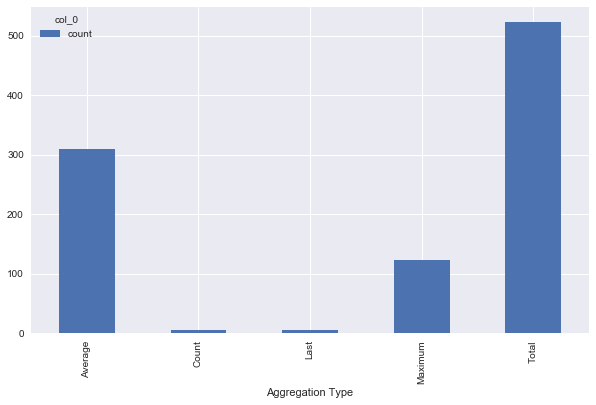

In [276]:
ct = pd.crosstab(df['Aggregation Type'], 'count')
print (ct)

ct.plot(kind='bar', figsize=(10, 6))

### Unit

col_0           count
Unit                 
Bytes             125
BytesPerSecond     37
Count             637
CountPerSecond     29
MilliSeconds        2
Milliseconds       24
Percent            80
Seconds            31


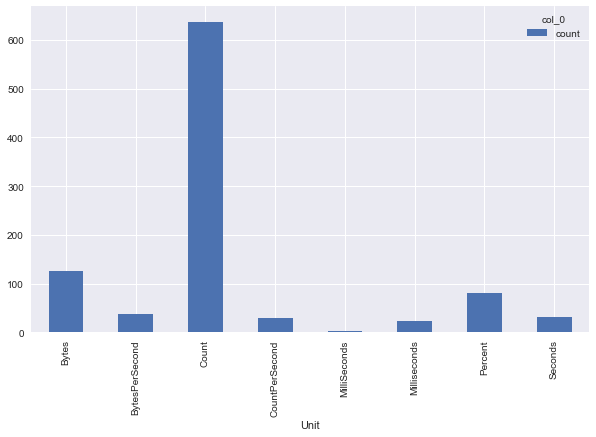

In [277]:
ct = pd.crosstab(df['Unit'], 'count')
print (ct)

ct.plot(kind='bar', figsize=(10, 6))

### Metric & Metric Display Name

It seems more everyone has configured the metric name differently - let's see if we can use charecter level (n-gram) vectorization to cluster similar ones;

In [287]:
df['MetricProcessed'] = df['Metric'].apply(lambda x: ''.join(ch for ch in x.lower() if ch.isalpha()))

In [289]:
import re
metric = df['Metric'].values
metric = np.unique(np.array(metric))

print ("No of metrics before pre-processing: %d" % metric.shape[0])
for i, m in enumerate(metric):
    metric[i] = ''.join(ch for ch in m.lower() if ch.isalpha())

metric = np.unique(np.array(metric))
print ("No of metrics after pre-processing: %d" % metric.shape[0])

No of metrics before pre-processing: 752
No of metrics after pre-processing: 583


In [290]:
cv = CountVectorizer(analyzer='char', ngram_range=(1,4))
vectors = cv.fit_transform(metric)
vectors = vectors.toarray()
vectors.shape

(583, 4473)

In [291]:
cluster = DBSCAN(eps=4.5, min_samples=2)
cluster.fit(vectors)

mdf = pd.DataFrame(metric, columns=['metric'])
mdf['label'] = cluster.labels_
# mdf['label'].value_counts()

In [292]:
print ("No of clusters: %d" % (mdf['label'].max() + 1))
for i in range(mdf['label'].max()):
    print ("label %d" % i)
    print (mdf[mdf['label'] == i])
    print ()

No of clusters: 58
label 0
              metric  label
22      availability      0
217  dipavailability      0
574  vipavailability      0

label 1
                        metric  label
23      averageavailablembytes      1
25  averageavailablembytesswap      1

label 2
                      metric  label
39  averagediskwritebytessec      2
40      averagediskwritessec      2

label 3
                      metric  label
57  averagepctprivilegedtime      3
60     averageprivilegedtime      3

label 4
                  metric  label
73  averagetotalrxerrors      4
74  averagetotaltxerrors      4

label 5
                     metric  label
79  averageusedmemorykbytes      5
80  averageusedmemorymbytes      5

label 6
             metric  label
83     averageusers      6
84  averageusertime      6

label 7
            metric  label
90    blobcapacity      7
105       capacity      7
255   filecapacity      7
503  tablecapacity      7
568   usedcapacity      7

label 8
                  met

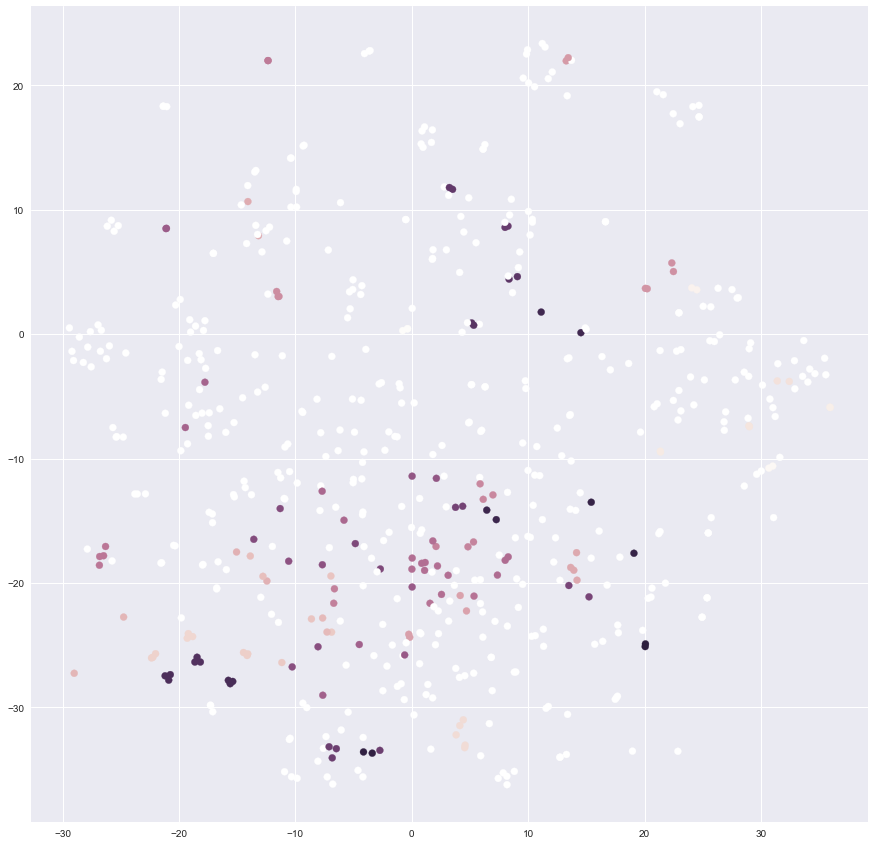

In [293]:
vectors_reduced = TSNE(n_components=2).fit_transform(vectors)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.figure(figsize=(15, 15))
cluster.labels_ + 100

scatter = plt.scatter(vectors_reduced[:, 0], vectors_reduced[:, 1], label=cluster.labels_, c=cluster.labels_, cmap=cmap)

In [307]:
md = {}
for i, key in enumerate(metric):
    md[key] = i

cindex = {}
def getClusteredMetric(metric):
    i = cluster.labels_[md[metric]]
    if (i == -1):
        return metric
    
    if i in cindex:
        return cindex[i]
    else:
        cindex[i] = metric
        return metric

In [308]:
j = -1
df['MetricClustered'] = df['MetricProcessed'].apply(lambda x: getClusteredMetric(x))

In [311]:
df.columns

Index(['Aggregation Type', 'Description', 'Dimensions', 'Metric',
       'Metric Display Name', 'Unit', 'resource', 'ResourceNamespace',
       'ResourceName', 'MetricProcessed', 'MetricClustered'],
      dtype='object')

In [326]:
_ct = pd.crosstab(df['resource'], df['MetricClustered'])

In [338]:
clstr = KMeans(n_clusters=20)
clstr.fit(_ct.values)
labels = clstr.labels_
labels

array([ 7,  0,  0, 16,  1, 13, 13,  2, 13, 13, 13,  0, 18,  2,  2,  0,  0,
        0,  0,  0,  4,  4,  0,  0,  6,  0, 17,  0,  0, 15,  0,  0,  0,  0,
        0, 10,  0,  0,  5,  9,  0,  0,  0, 11,  0,  8,  8, 14, 14, 14, 14,
       14, 12,  3,  0,  0, 19,  0, 19])

In [351]:
_df1 = pd.DataFrame(data=_ct.index)
_df1['labels'] = labels
for i in range(_df1['labels'].max()):
    print ("LABEL %d" % i)
    print (_df[_df['labels'] == i]['resource'])
    print ('--------------------------------------------------')

LABEL 0
1                       Microsoft.ApiManagement/service
2               Microsoft.Automation/automationAccounts
11          Microsoft.ContainerInstance/containerGroups
15                  Microsoft.DataFactory/datafactories
16                      Microsoft.DataFactory/factories
17                 Microsoft.DataLakeAnalytics/accounts
18                     Microsoft.DataLakeStore/accounts
19                       Microsoft.Devices/ElasticPools
22               Microsoft.Devices/provisioningServices
23                Microsoft.DocumentDB/databaseAccounts
25                         Microsoft.HDInsight/clusters
27                            Microsoft.KeyVault/vaults
28             Microsoft.LocationBasedServices/accounts
30                Microsoft.Network/applicationGateways
31                           Microsoft.Network/dnszones
32               Microsoft.Network/expressRouteCircuits
33                      Microsoft.Network/loadBalancers
34    Microsoft.Network/networkWatchers/